<h1><center>IST 597 Foundations of Deep Learning</center></h1>

---

<h2><center>Assignment 11</center><h2>

**Instructor** : Dr. C. Lee Giles <br>
**TA** : Neisarg Dave, Shaurya Rohatgi
<br><br>

Credits: 

<h3>Course Policy<h3>

Carefully read all the instructions, before you start working on the assignment

* Give maximum explanation for each sub-problems.

* Please avoid single line answers, submissions without any explanations would receive 0 points.

* Late submissions will be graded with 20% discount per day. Day 1 starts immediately after the submission deadline.

* Every assignment has a hard deadline, usually 3 days past the original due date.

* Late submissions (penalty or not) are not accepted after the hard deadline.

* All source materials must be cited. The University Academic Code of Conduct will be strictly enforced.

* We will be creating Canvas submission page for this. Submit all files on Canvas.

* All queries related to Assignment should have a subject line *IST597:Assignment_11 Queries*

---


<h2><center>Convolution Neural Networks</center></h2>

---

#### What is Convolution

3Blue1Brown explains it best:

https://www.youtube.com/watch?v=KuXjwB4LzSA

In practice, especially for images, instead of performing convolution, we perform cross correlation operation (and call it Convolution !!)

What is the difference?
Cross correlation is performing colvolution, but without inverting the kernel function. 

https://en.wikipedia.org/wiki/Cross-correlation

<br>

#### Learnable Convolution Kernels

Convolution Neural Networks are composed of multiple layers of cross-correlation operators with learnable kernels.

<br>

#### Max Pooling

Max pooling is a pooling technique where we select the max value from the image masked by the max pooling kernel. We then slide this kernel across our image, resulting in a smaller image. 

https://www.youtube.com/watch?v=ZjM_XQa5s6s

<br>

#### Conv Layers in PyToch
We will use 2D conv layers and max pool layers from PyTorch to create our model

+ https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
+ https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

---



This assignment has 3 tasks:
1. Training a ConvNet on CIFAR10 dataset
2. Data Augmentation 
3. Adversarial Samples

You can change your model hyperparameters for task 1, keep the model structure same for tasks 2 and 3

You can use inbuilt torch or sklearn functionalities wherever possible.

Provide detailed explaination for each observation.


In [1]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pprint
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

device = torch.device("cuda:0")

seed = 1234 
random.seed(seed)
torch.manual_seed(seed)

In [2]:
train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [3]:
class_to_idx = {
    "airplane"    : 0,
    "automobile"  : 1,
    "bird"        : 2,
    "cat"         : 3,
    "deer"        : 4,
    "dog"         : 5,
    "frog"        : 6,
    "horse"       : 7,
    "ship"        : 8,
    "truck"       : 9
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

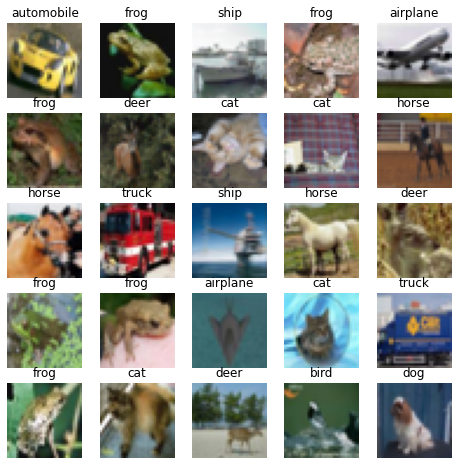

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    label = idx_to_class[label]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze())
plt.show()

## Task 1
Train a decently fit (no underfitting or overfitting) neural network on the CIFAR 10 dataset. 
+ Keep track of your validation loss to select the best model
+ You are free to change network hyperparameters and batch size
+ You are free to change optimizer settings and loss function
+ Run your model 5 times with different seeds and report mean and standard deviation of the following metrices on Test Set:
  1. Accuracy for each class
  2. Precision for each class
  3. Recall for each class
  4. F1 score for each class
  5. Visualize the Confusion Matrix (use only mean values for this)



In [5]:
import random

random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

## Sample Classification Network

class ConvolutionNeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(ConvolutionNeuralNetwork, self).__init__()
    self.conv = torch.nn.Sequential(
      torch.nn.Conv2d(3, 64, 5),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 128, 5),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2),
      torch.nn.Conv2d(128, 128, [5,5]),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 128, [5,5]),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2,2)
    )

    self.fc1 = torch.nn.Linear(512, 128)
    self.fc2 = torch.nn.Linear(128, 128)
    self.fc3 = torch.nn.Linear(128, 10)
  
  def forward(self, data):
    bs = data.shape[0]
    data = self.conv(data)
    data = data.reshape(bs, -1)
    data = torch.relu(self.fc1(data))
    data = torch.relu(self.fc2(data))
    logits = self.fc3(data)
    return logits

In [6]:
batch_size = 1024
train_data = DataLoader(train_dataset, batch_size = batch_size)
test_data = DataLoader(test_dataset, batch_size = batch_size)
val_data = DataLoader(val_dataset, batch_size = batch_size)

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)

print_every = 500
train_loss = []
train_acc = []
val_loss = []
val_acc = []
num_epochs = 5
max_val_loss = np.inf
best_model = None

Run: 1, Epoch: 1/10, Train Loss: 2303.4742, Train Acc: 101.3250, Val Loss: 2303.2766, Val Acc: 94.7000
Run: 1, Epoch: 2/10, Train Loss: 2302.5551, Train Acc: 101.3250, Val Loss: 2302.4977, Val Acc: 94.7000
Run: 1, Epoch: 3/10, Train Loss: 2302.0387, Train Acc: 101.3250, Val Loss: 2301.9380, Val Acc: 94.7000
Run: 1, Epoch: 4/10, Train Loss: 2301.4788, Train Acc: 101.3250, Val Loss: 2301.2096, Val Acc: 94.7000
Run: 1, Epoch: 5/10, Train Loss: 2300.4881, Train Acc: 124.2500, Val Loss: 2299.7155, Val Acc: 158.1000
Run: 1, Epoch: 6/10, Train Loss: 2297.9962, Train Acc: 175.9750, Val Loss: 2295.3645, Val Acc: 177.1000
Run: 1, Epoch: 7/10, Train Loss: 2287.8655, Train Acc: 180.4250, Val Loss: 2269.9109, Val Acc: 181.3000
Run: 1, Epoch: 8/10, Train Loss: 2201.4615, Train Acc: 181.5750, Val Loss: 2132.1237, Val Acc: 202.9000
Run: 1, Epoch: 9/10, Train Loss: 2090.2206, Train Acc: 207.3500, Val Loss: 2063.5320, Val Acc: 223.1000
Run: 1, Epoch: 10/10, Train Loss: 2044.5905, Train Acc: 231.5750, Va

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 2, Epoch: 1/10, Train Loss: 1993.7086, Train Acc: 260.0750, Val Loss: 1960.7512, Val Acc: 277.9000
Run: 2, Epoch: 2/10, Train Loss: 1923.0238, Train Acc: 285.7000, Val Loss: 1954.2541, Val Acc: 285.6000
Run: 2, Epoch: 3/10, Train Loss: 1853.5129, Train Acc: 313.5000, Val Loss: 1849.4980, Val Acc: 311.2000
Run: 2, Epoch: 4/10, Train Loss: 1847.2053, Train Acc: 319.1750, Val Loss: 1799.4107, Val Acc: 330.5000
Run: 2, Epoch: 5/10, Train Loss: 1760.0800, Train Acc: 346.7500, Val Loss: 1879.0888, Val Acc: 306.5000
Run: 2, Epoch: 6/10, Train Loss: 1757.6956, Train Acc: 351.5250, Val Loss: 1714.9339, Val Acc: 360.2000
Run: 2, Epoch: 7/10, Train Loss: 1698.6333, Train Acc: 369.5000, Val Loss: 1759.8659, Val Acc: 350.1000
Run: 2, Epoch: 8/10, Train Loss: 1678.8484, Train Acc: 376.5500, Val Loss: 1701.1299, Val Acc: 370.9000
Run: 2, Epoch: 9/10, Train Loss: 1645.3845, Train Acc: 388.8500, Val Loss: 1667.4291, Val Acc: 381.5000
Run: 2, Epoch: 10/10, Train Loss: 1607.7872, Train Acc: 400.3250

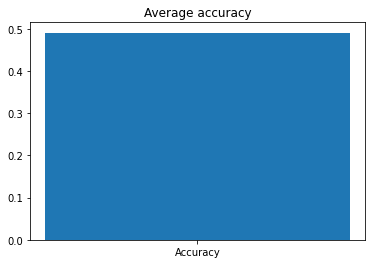

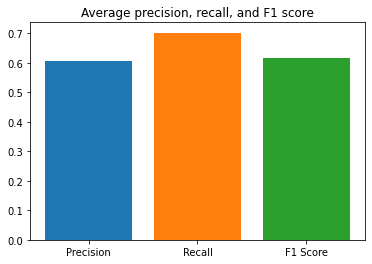

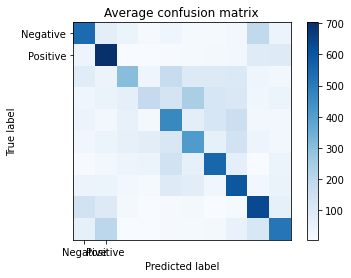

In [7]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

# Define lists to store metrics for each run
all_acc = []
all_prec = []
all_recall = []
all_f1 = []
all_cm = []

# Define hyperparameters
num_epochs = 10
print_every = 1
learning_rate = 0.001
batch_size = 1024

# Define model, loss function, and optimizer

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)


# Define data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size)

# Run the model 5 times with different seeds
for run in range(5):
    # Set random seed for this run
    np.random.seed(run)
    torch.manual_seed(run)

    # Initialize best validation loss
    best_val_loss = np.inf

    # Train and evaluate the model for each epoch
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        train_loss = 0.0
        train_true_pos = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_true_pos += torch.sum(preds == labels.data)
        train_loss /= len(train_data)
        train_acc = train_true_pos.double() / len(train_data)

        # Evaluate the model on validation set
        model.eval()
        val_loss = 0.0
        val_true_pos = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_true_pos += torch.sum(preds == labels.data)
                val_preds += preds.tolist()
                val_labels += labels.tolist()
        val_loss /= len(val_data)
        val_acc = val_true_pos.double() / len(val_data)

        # Select the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        # Print training and validation metrics
        if (epoch+1) % print_every == 0:
            print(f'Run: {run+1}, Epoch: {epoch+1}/{num_epochs},',
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},',
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Evaluate the best model on test set
    model.load_state_dict(best_model)
    model.eval()
    test_true_pos = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_true_pos += torch.sum(preds == labels.data)
            test_preds += preds.tolist()
            test_labels += labels.tolist()
    test_acc = test_true_pos.double() / len(test_data)
    
    # Calculate and store metrics for this run
    accuracy, precision, recall, f1, cm = calculate_metrics(test_labels, test_preds)
    all_acc.append(accuracy)
    all_prec.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_cm.append(cm)
    
# Print average metrics across runs
print(f'Average accuracy: {np.mean(all_acc):.4f}')
print(f'Average precision: {np.mean(all_prec, axis=0)}')
print(f'Average recall: {np.mean(all_recall, axis=0)}')
print(f'Average F1 score: {np.mean(all_f1, axis=0)}')
print(f'Average confusion matrix:\n{np.mean(all_cm, axis=0)}')


import matplotlib.pyplot as plt

# Plot average accuracy
plt.bar(['Accuracy'], [np.mean(all_acc)])
plt.title('Average accuracy')
plt.show()

# Plot average precision, recall, and F1 score
metrics = ['Precision', 'Recall', 'F1 Score']
values = [np.mean(all_prec, axis=0), np.mean(all_recall, axis=0), np.mean(all_f1, axis=0)]
for i in range(len(metrics)):
    plt.bar(metrics[i], values[i])
plt.title('Average precision, recall, and F1 score')
plt.show()

# Plot average confusion matrix
plt.imshow(np.mean(all_cm, axis=0), cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Average confusion matrix')
plt.show()

## Task 2: Data Augmentation

Perform the following data augmentation techniques to increase the number of samples in your train set:

1. Rotate Image at an arbitrary angle 
2. Crop Image from the center and resize
3. Flip Image from left to right (Create a mirror image)

Train your network on the augmented dataset 5 times with different seeds and campare results with previously trained network on Test Set.

In [8]:
batch_size = 1024

train_transforms = T.Compose([
    T.RandomRotation(degrees=30),
    T.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_augmented_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transforms
)

train_augmented_data, _ = torch.utils.data.random_split(train_augmented_dataset, [40000, 10000])

train_augmented_loader = DataLoader(train_augmented_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [9]:
train_loader = DataLoader(train_augmented_data, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)

print_every = 500
train_loss = []
train_acc = []
val_loss = []
val_acc = []
num_epochs = 5
max_val_loss = np.inf
best_model = None

Run: 1, Epoch: 1/10, Train Loss: 2303.2942, Train Acc: 99.7000, Val Loss: 2303.3034, Val Acc: 100.1000
Run: 1, Epoch: 2/10, Train Loss: 2302.1923, Train Acc: 101.3500, Val Loss: 2302.6548, Val Acc: 100.1000
Run: 1, Epoch: 3/10, Train Loss: 2301.3156, Train Acc: 106.0750, Val Loss: 2302.3269, Val Acc: 100.4000
Run: 1, Epoch: 4/10, Train Loss: 2299.7816, Train Acc: 124.9250, Val Loss: 2301.9630, Val Acc: 101.2000
Run: 1, Epoch: 5/10, Train Loss: 2294.9858, Train Acc: 148.3000, Val Loss: 2301.2647, Val Acc: 100.7000
Run: 1, Epoch: 6/10, Train Loss: 2266.5226, Train Acc: 160.8500, Val Loss: 2333.9401, Val Acc: 100.7000
Run: 1, Epoch: 7/10, Train Loss: 2111.2757, Train Acc: 204.9750, Val Loss: 2202.1560, Val Acc: 140.1000
Run: 1, Epoch: 8/10, Train Loss: 1991.7162, Train Acc: 262.5750, Val Loss: 2140.7366, Val Acc: 168.4000
Run: 1, Epoch: 9/10, Train Loss: 1888.2337, Train Acc: 299.5250, Val Loss: 2450.1646, Val Acc: 151.2000
Run: 1, Epoch: 10/10, Train Loss: 1828.9843, Train Acc: 318.2500,

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 2, Epoch: 1/10, Train Loss: 1789.4026, Train Acc: 338.5500, Val Loss: 2558.8019, Val Acc: 134.6000
Run: 2, Epoch: 2/10, Train Loss: 1744.1916, Train Acc: 353.8000, Val Loss: 2574.3748, Val Acc: 138.5000
Run: 2, Epoch: 3/10, Train Loss: 1691.6264, Train Acc: 373.5250, Val Loss: 2497.5612, Val Acc: 150.1000
Run: 2, Epoch: 4/10, Train Loss: 1653.5234, Train Acc: 389.0750, Val Loss: 2434.0061, Val Acc: 177.0000
Run: 2, Epoch: 5/10, Train Loss: 1619.6172, Train Acc: 400.6250, Val Loss: 2564.4887, Val Acc: 146.6000
Run: 2, Epoch: 6/10, Train Loss: 1590.2537, Train Acc: 414.8250, Val Loss: 2526.6412, Val Acc: 144.1000
Run: 2, Epoch: 7/10, Train Loss: 1566.7746, Train Acc: 424.0250, Val Loss: 2591.3615, Val Acc: 152.5000
Run: 2, Epoch: 8/10, Train Loss: 1541.2142, Train Acc: 432.3000, Val Loss: 2519.9403, Val Acc: 160.0000
Run: 2, Epoch: 9/10, Train Loss: 1518.6347, Train Acc: 438.2500, Val Loss: 2410.3993, Val Acc: 189.9000
Run: 2, Epoch: 10/10, Train Loss: 1497.3643, Train Acc: 449.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 3, Epoch: 1/10, Train Loss: 1469.9555, Train Acc: 459.4250, Val Loss: 2314.6307, Val Acc: 190.7000
Run: 3, Epoch: 2/10, Train Loss: 1440.6892, Train Acc: 472.9750, Val Loss: 2101.4788, Val Acc: 234.0000
Run: 3, Epoch: 3/10, Train Loss: 1431.4678, Train Acc: 478.1250, Val Loss: 2190.0863, Val Acc: 214.7000
Run: 3, Epoch: 4/10, Train Loss: 1395.1277, Train Acc: 490.9500, Val Loss: 2173.7246, Val Acc: 242.3000
Run: 3, Epoch: 5/10, Train Loss: 1386.8621, Train Acc: 493.9000, Val Loss: 1959.5035, Val Acc: 269.6000
Run: 3, Epoch: 6/10, Train Loss: 1365.7936, Train Acc: 506.3250, Val Loss: 1989.6754, Val Acc: 281.7000
Run: 3, Epoch: 7/10, Train Loss: 1351.3233, Train Acc: 513.0500, Val Loss: 1943.7978, Val Acc: 281.9000
Run: 3, Epoch: 8/10, Train Loss: 1320.1532, Train Acc: 523.7250, Val Loss: 2078.1885, Val Acc: 286.8000
Run: 3, Epoch: 9/10, Train Loss: 1305.2649, Train Acc: 528.3500, Val Loss: 2030.9241, Val Acc: 288.9000
Run: 3, Epoch: 10/10, Train Loss: 1277.8775, Train Acc: 543.3750

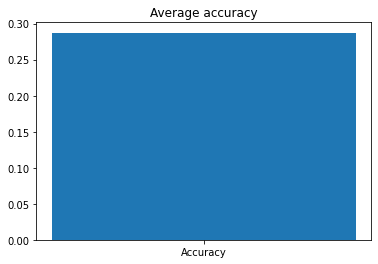

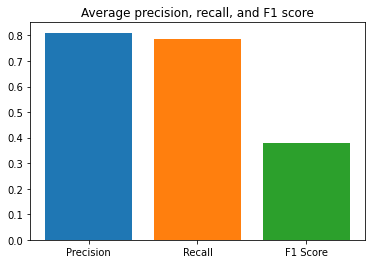

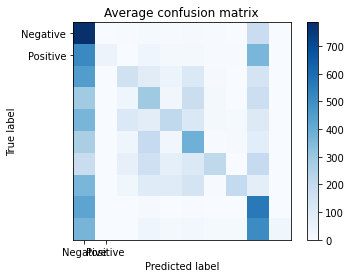

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

# Define lists to store metrics for each run
all_acc = []
all_prec = []
all_recall = []
all_f1 = []
all_cm = []

# Define hyperparameters
num_epochs = 10
print_every = 1
learning_rate = 0.001
batch_size = 1024


# Run the model 5 times with different seeds
for run in range(5):
    # Set random seed for this run
    np.random.seed(run)
    torch.manual_seed(run)

    # Initialize best validation loss
    best_val_loss = np.inf

    # Train and evaluate the model for each epoch
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        train_loss = 0.0
        train_true_pos = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_true_pos += torch.sum(preds == labels.data)
        train_loss /= len(train_data)
        train_acc = train_true_pos.double() / len(train_data)

        # Evaluate the model on validation set
        model.eval()
        val_loss = 0.0
        val_true_pos = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_true_pos += torch.sum(preds == labels.data)
                val_preds += preds.tolist()
                val_labels += labels.tolist()
        val_loss /= len(val_data)
        val_acc = val_true_pos.double() / len(val_data)

        # Select the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        # Print training and validation metrics
        if (epoch+1) % print_every == 0:
            print(f'Run: {run+1}, Epoch: {epoch+1}/{num_epochs},',
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},',
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Evaluate the best model on test set
    model.load_state_dict(best_model)
    model.eval()
    test_true_pos = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_true_pos += torch.sum(preds == labels.data)
            test_preds += preds.tolist()
            test_labels += labels.tolist()
    test_acc = test_true_pos.double() / len(test_data)
    
    # Calculate and store metrics for this run
    accuracy, precision, recall, f1, cm = calculate_metrics(test_labels, test_preds)
    all_acc.append(accuracy)
    all_prec.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_cm.append(cm)
    
# Print average metrics across runs
print(f'Average accuracy: {np.mean(all_acc):.4f}')
print(f'Average precision: {np.mean(all_prec, axis=0)}')
print(f'Average recall: {np.mean(all_recall, axis=0)}')
print(f'Average F1 score: {np.mean(all_f1, axis=0)}')
print(f'Average confusion matrix:\n{np.mean(all_cm, axis=0)}')


import matplotlib.pyplot as plt

# Plot average accuracy
plt.bar(['Accuracy'], [np.mean(all_acc)])
plt.title('Average accuracy')
plt.show()

# Plot average precision, recall, and F1 score
metrics = ['Precision', 'Recall', 'F1 Score']
values = [np.mean(all_prec, axis=0), np.mean(all_recall, axis=0), np.mean(all_f1, axis=0)]
for i in range(len(metrics)):
    plt.bar(metrics[i], values[i])
plt.title('Average precision, recall, and F1 score')
plt.show()

# Plot average confusion matrix
plt.imshow(np.mean(all_cm, axis=0), cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Average confusion matrix')
plt.show()


## Task 3: Adversarial Samples

1. Create a Adversarial Test Set by adding a noise sampled from $\sim\mathcal{N}(\mu = 0, \sigma = 0.01)$ to the given Test Set.
2. Compare models obtained in Task 1 and Task 2 on Adversarial Test Set
3. Augment train set by adding noise to samples from train set. (You should have both normal samples and noise added samples in train set)
4. Train your model 5 times with different seeds on noise augmented train set and report results on normal Test Set and Adversarial Test Set 

In [11]:
import torch
import copy
from torch.utils.data import TensorDataset

train_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

# Load the CIFAR10 test dataset
test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

# Create a copy of the test dataset and add noise to the images
adversarial_test_images = []
adversarial_test_labels = []
for image, label in test_dataset:
    noise = torch.randn_like(image) * 0.01
    image = torch.clamp(image + noise, min=0, max=1)
    adversarial_test_images.append(image)
    adversarial_test_labels.append(label)
adversarial_test_dataset = TensorDataset(torch.stack(adversarial_test_images), torch.tensor(adversarial_test_labels))

val_dataset, train_dataset = torch.utils.data.random_split(train_dataset, [10000, 40000])

print(len(train_dataset), len(val_dataset), len(adversarial_test_dataset))


Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [12]:
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size = batch_size)
test_loader = DataLoader(adversarial_test_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)

loss_fn = torch.nn.CrossEntropyLoss()
model = ConvolutionNeuralNetwork().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0, momentum = 0.9)

print_every = 500
train_loss = []
train_acc = []
val_loss = []
val_acc = []
num_epochs = 5
max_val_loss = np.inf
best_model = None

Run: 1, Epoch: 1/10, Train Loss: 2303.2856, Train Acc: 100.3500, Val Loss: 2303.1282, Val Acc: 98.6000
Run: 1, Epoch: 2/10, Train Loss: 2302.4970, Train Acc: 100.3500, Val Loss: 2302.4796, Val Acc: 98.6000
Run: 1, Epoch: 3/10, Train Loss: 2301.9931, Train Acc: 100.3250, Val Loss: 2301.8616, Val Acc: 99.6000
Run: 1, Epoch: 4/10, Train Loss: 2301.1441, Train Acc: 114.4750, Val Loss: 2300.5780, Val Acc: 146.7000
Run: 1, Epoch: 5/10, Train Loss: 2299.0105, Train Acc: 143.2250, Val Loss: 2296.9869, Val Acc: 160.8000
Run: 1, Epoch: 6/10, Train Loss: 2291.1798, Train Acc: 169.4750, Val Loss: 2279.5754, Val Acc: 179.2000
Run: 1, Epoch: 7/10, Train Loss: 2213.8771, Train Acc: 180.0000, Val Loss: 2097.1147, Val Acc: 191.6000
Run: 1, Epoch: 8/10, Train Loss: 2094.6569, Train Acc: 205.5250, Val Loss: 2053.5322, Val Acc: 207.2000
Run: 1, Epoch: 9/10, Train Loss: 2028.2267, Train Acc: 236.1750, Val Loss: 2000.0161, Val Acc: 241.7000
Run: 1, Epoch: 10/10, Train Loss: 1978.0423, Train Acc: 265.3000, V

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Run: 2, Epoch: 1/10, Train Loss: 2000.6762, Train Acc: 269.9500, Val Loss: 2032.7194, Val Acc: 251.8000
Run: 2, Epoch: 2/10, Train Loss: 1909.8432, Train Acc: 298.5750, Val Loss: 1845.9338, Val Acc: 314.2000
Run: 2, Epoch: 3/10, Train Loss: 1851.3157, Train Acc: 322.6250, Val Loss: 1793.3182, Val Acc: 334.8000
Run: 2, Epoch: 4/10, Train Loss: 1780.7892, Train Acc: 345.9500, Val Loss: 1770.7049, Val Acc: 342.5000
Run: 2, Epoch: 5/10, Train Loss: 1759.1318, Train Acc: 349.7750, Val Loss: 1737.8229, Val Acc: 353.8000
Run: 2, Epoch: 6/10, Train Loss: 1712.7575, Train Acc: 365.3750, Val Loss: 1710.5585, Val Acc: 359.5000
Run: 2, Epoch: 7/10, Train Loss: 1699.1325, Train Acc: 371.3750, Val Loss: 1681.4326, Val Acc: 370.2000
Run: 2, Epoch: 8/10, Train Loss: 1654.1629, Train Acc: 386.1500, Val Loss: 1652.9394, Val Acc: 380.6000
Run: 2, Epoch: 9/10, Train Loss: 1632.6430, Train Acc: 394.5500, Val Loss: 1635.7902, Val Acc: 392.7000
Run: 2, Epoch: 10/10, Train Loss: 1596.7164, Train Acc: 408.2750

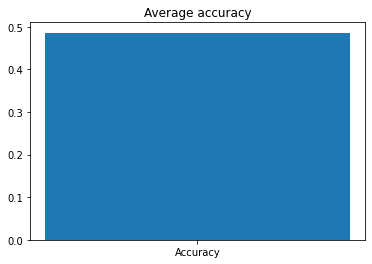

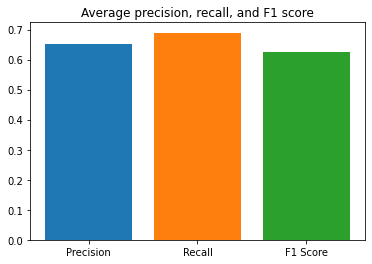

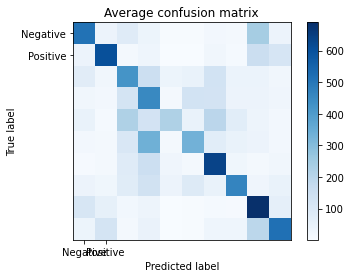

In [13]:
#--------------------------
# Write your Code Here

import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define function to calculate metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

# Define lists to store metrics for each run
all_acc = []
all_prec = []
all_recall = []
all_f1 = []
all_cm = []

# Define hyperparameters
num_epochs = 10
print_every = 1
learning_rate = 0.001
batch_size = 1024


# Run the model 5 times with different seeds
for run in range(5):
    # Set random seed for this run
    np.random.seed(run)
    torch.manual_seed(run)

    # Initialize best validation loss
    best_val_loss = np.inf

    # Train and evaluate the model for each epoch
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        train_loss = 0.0
        train_true_pos = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_true_pos += torch.sum(preds == labels.data)
        train_loss /= len(train_data)
        train_acc = train_true_pos.double() / len(train_data)

        # Evaluate the model on validation set
        model.eval()
        val_loss = 0.0
        val_true_pos = 0
        val_preds = []
        val_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.cuda(), labels.cuda()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_true_pos += torch.sum(preds == labels.data)
                val_preds += preds.tolist()
                val_labels += labels.tolist()
        val_loss /= len(val_data)
        val_acc = val_true_pos.double() / len(val_data)

        # Select the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

        # Print training and validation metrics
        if (epoch+1) % print_every == 0:
            print(f'Run: {run+1}, Epoch: {epoch+1}/{num_epochs},',
                  f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f},',
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Evaluate the best model on test set
    model.load_state_dict(best_model)
    model.eval()
    test_true_pos = 0
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_true_pos += torch.sum(preds == labels.data)
            test_preds += preds.tolist()
            test_labels += labels.tolist()
    test_acc = test_true_pos.double() / len(test_data)
    
    # Calculate and store metrics for this run
    accuracy, precision, recall, f1, cm = calculate_metrics(test_labels, test_preds)
    all_acc.append(accuracy)
    all_prec.append(precision)
    all_recall.append(recall)
    all_f1.append(f1)
    all_cm.append(cm)
    
# Print average metrics across runs
print(f'Average accuracy: {np.mean(all_acc):.4f}')
print(f'Average precision: {np.mean(all_prec, axis=0)}')
print(f'Average recall: {np.mean(all_recall, axis=0)}')
print(f'Average F1 score: {np.mean(all_f1, axis=0)}')
print(f'Average confusion matrix:\n{np.mean(all_cm, axis=0)}')


import matplotlib.pyplot as plt

# Plot average accuracy
plt.bar(['Accuracy'], [np.mean(all_acc)])
plt.title('Average accuracy')
plt.show()

# Plot average precision, recall, and F1 score
metrics = ['Precision', 'Recall', 'F1 Score']
values = [np.mean(all_prec, axis=0), np.mean(all_recall, axis=0), np.mean(all_f1, axis=0)]
for i in range(len(metrics)):
    plt.bar(metrics[i], values[i])
plt.title('Average precision, recall, and F1 score')
plt.show()

# Plot average confusion matrix
plt.imshow(np.mean(all_cm, axis=0), cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Average confusion matrix')
plt.show()

#--------------------------